## Monte Carlo simulation to forecast the future value of a stock portfolio and computing it's VaR (Value at Risk) and CVaR (Conditional Value at Risk)


In [20]:
import numpy as np #Importing necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
from pandas_datareader import data as pdr
import yfinance as yf

Just trying to predict a stock price (Assuming it follows a General Brownian Motion)

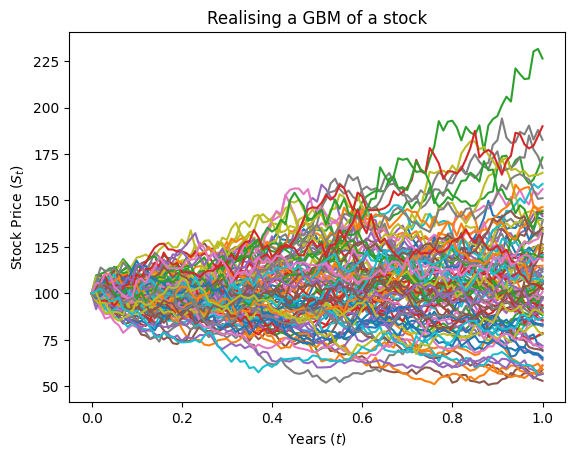

In [21]:
mu=0.1 #Drift Coefficient
n=100 #Number of steps
T=1  #Time in years
M=100 #Number of simulations
S0=100 #Initial Stock price
sigma=0.3 #Volatility
time=np.linspace(0,T,n+1)
tt=np.full(shape=(M,n+1),fill_value=time).T

dt=T/n  #Single Time Step
S_deltat=np.exp((mu-sigma**2/2)*dt+sigma*np.random.normal(0,np.sqrt(dt),size=(M,n)).T) #GBM equation

S_deltat=np.vstack([np.ones(M),S_deltat]) #Multiplicative factor
St=S0*S_deltat.cumprod(axis=0)  #Stock Price at time T

plt.plot(tt,St)
plt.title("Realising a GBM of a stock")
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.show()

### Getting the mean returns of each stock in the portfolio and also the covariance matrix between all of them

In [22]:
def get_data(stocks, start, end):
    data = yf.download(stocks, start=start, end=end)['Close']
    
    # If single stock, convert to DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()

    returns = data.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    return mean_returns, cov_matrix

In [23]:
stockList=['AAPL','MSFT', 'GOOG'] # Sample Stocks

endDate=datetime.datetime.now()
startDate=endDate-datetime.timedelta(days=300)
data = yf.download("AAPL", start=startDate, end=endDate)
meanReturns,covMatrix=get_data(stockList,startDate,endDate)

# print(data)

print(meanReturns,covMatrix)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  3 of 3 completed

Ticker
AAPL   -0.000072
GOOG    0.000437
MSFT    0.000862
dtype: float64 Ticker      AAPL      GOOG      MSFT
Ticker                              
AAPL    0.000451  0.000227  0.000215
GOOG    0.000227  0.000417  0.000197
MSFT    0.000215  0.000197  0.000280


## Running the Monte Carlo Simulation

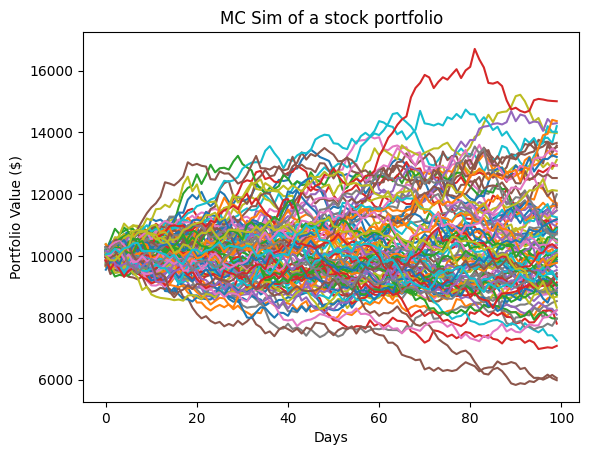

In [ ]:
mc_sims=100
T=100

meanM=np.full(shape=(T,len(meanReturns)),fill_value=meanReturns).T
initialPortfolio = 10000
portfolio_sims=np.full(shape=(T,mc_sims),fill_value=0)

for m in range(mc_sims):
    weights=np.random.random(len(meanReturns)) #Investing some percentage in each stock
    weights /=np.sum(weights)
    Z=np.random.normal(size=(T,len(weights)))
    L=np.linalg.cholesky(covMatrix)
    dailyReturns=meanM+np.inner(L,Z) #Using Cholesky decomposition to get Correlated Brownian Motions
    portfolio_sims[:,m]=np.cumprod(np.inner(weights,dailyReturns.T)+1)*initialPortfolio
    
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC Sim of a stock portfolio')
plt.show()

## Now I am computing the VaR and CVar from the portfolios simulated by Monte Carlo method

In [27]:
def mcVaR(returns, alpha=5): 
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
    
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print(f'VaR {round(VaR,2)} $')
print(f'CVaR {round(CVaR,2)} $')

VaR 2038.9 $
CVaR 3163.4 $
